In [10]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, MultipleLocator
import numpy as np
from copy import deepcopy
from cmcrameri import cm

import scipy.integrate as integ

In [2]:
# %matplotlib widget

%matplotlib inline
# %config InlineBackend.figure_format='retina'

In [3]:
# constants
sbc = 5.67e-8   # stefan-boltzman constant
M_E = 6e24 # Rarth mass [kg]
day = 24.0*60*60 # length of day in seconds
year = 365.24 * day

In [4]:
class planet():

    def __init__(self):

        # parameters
        self.c_p = 1250.0     # heat capacity [J kg-1 K-1]
        self.rho = 4550.0    # density [kg m-3]
        self.S_0 = 24.7*1361.0    # instellation [W m-2]
        self.T_0 = 3500.0    # initial temperature [K]
        self.T_s = 1500.0    # solidus temperature [K]
        self.T_l = 2000.0    # liquidus temperature [K]
        self.alb = 0.3       # shortwave albedo
        self.ems = 0.7       # longwave emissivity
        self.M_p = 0.47 * M_E   # mass of planet [kg]

        self.F_i = 0.0       # internal heat production [W m-2]
        self.T_cen = 0.5*(self.T_s + self.T_l)
        self.T_wid = 0.5*(self.T_l - self.T_s)

        # result
        self.sol_x = None
        self.sol_y = None

    # Calculate melt fraction from temperature
    def _phi(self, tmp):
        if tmp <= self.T_s:
            # fully solid
            return 0.0
        elif tmp >= self.T_l:
            # fully liquid
            return 1.0
        else:
            # mushy
            return (tmp - self.T_s)/(self.T_l-self.T_s)

    # ODE to solve
    def _ode(self, t, y):

        # temperature at time = t
        Tt = y[0]

        # interior heating
        F_int = self.F_i * np.exp(-1.0 * ((Tt-self.T_cen)/self.T_wid)**2)

        # RHS
        coeff = (np.pi/self.c_p) * (3.0/4)**(2.0/3) * (self.rho * self.rho * self.M_p)**(-1.0/3)

        up = (4.0 * self.ems * sbc)*(Tt**4)
        dn = (self.S_0)*(1-self.alb) + (4.0)*(F_int)

        out = coeff * (dn-up)

        return (out,)

    # Evolve system over time
    def solve(self, t_max, nsamps=1000):

        t_span = (0,t_max*year*1.01)
        t_eval = np.append([0.1],np.logspace(np.log10(day), np.log10(t_max*year), nsamps))

        result = integ.solve_ivp(self._ode, t_span, (self.T_0,),
                                    first_step=day/10, t_eval=t_eval)

        self.sol_x = result.t / year
        self.sol_y = result.y[0]
        succ = result.success
        if not succ:
            print("Success:",succ)
            print("\t",result.message)

        return self.sol_x, self.sol_y



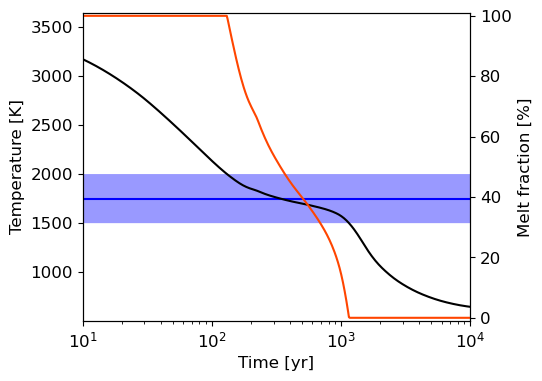

In [5]:
# single case
fig, ax = plt.subplots(1,1, figsize=(5,4))
axr = ax.twinx()

pl = planet()
pl.F_i = 3e5
sol_x, sol_y = pl.solve(1e4)
sol_p = [pl._phi(y)*100 for y in sol_y]

ax.fill_between(sol_x, pl.T_cen+pl.T_wid, pl.T_cen-pl.T_wid, color='b', alpha=0.4, edgecolor=None)
ax.axhline(pl.T_cen, color='b')

ax.plot(sol_x, sol_y, color='k')

ax.set_xlabel("Time [yr]")
ax.set_ylabel("Temperature [K]")
ax.set_xscale("log")
ax.set_xlim(10, sol_x[-1])

axr.plot(sol_x, sol_p, color='orangered')
axr.set_ylabel("Melt fraction [%]")
axr.set_ylim(bottom=-1, top=101)

plt.show()

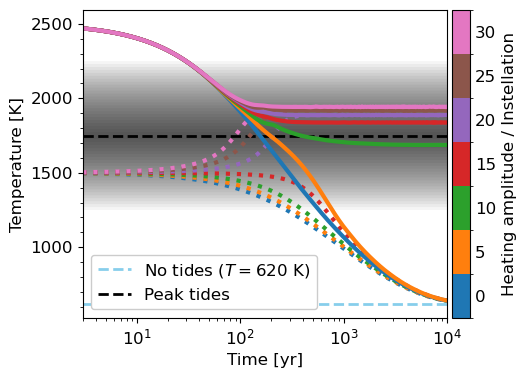

In [26]:
# multiple cases
fig, ax = plt.subplots(1,1, figsize=(5,4))

# null hypothesis
pl = planet()
sol_x, sol_y = pl.solve(t_max=1e6)
y_noh = float(sol_y[-1])
ax.axhline(y=y_noh, color='skyblue', linestyle='dashed', label=r"No tides ($T=%d$ K)"%y_noh, lw=2)

# mixed phase region
res = 25
for q in np.linspace(0.1, 2.0, res):
    ax.fill_between(sol_x, pl.T_cen+pl.T_wid*q, pl.T_cen-pl.T_wid*q, color='k', alpha=1.0/res, edgecolor=None)
ax.axhline(pl.T_cen, color='k', label="Peak tides", ls='dashed', lw=2)

dx = 5
x_arr = np.arange(0, 30.0+dx, dx)
lw = 3
cmap = "tab10"
norm = mpl.colors.BoundaryNorm(boundaries=np.append(x_arr, x_arr[-1]+dx)-dx/2, ncolors=len(x_arr))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(x_arr)
for x in x_arr:
    pl = planet()
    pl.T_0 = 1500
    pl.S_0
    pl.F_i = x * pl.S_0

    # solve and plot
    sol_x, sol_y = pl.solve(t_max=1e4)
    ax.plot(sol_x, sol_y, color=sm.to_rgba(x), ls='dotted', lw=lw)

for x in x_arr:
    pl = planet()
    pl.T_0 = 2500
    pl.F_i = x * pl.S_0

    # solve and plot
    sol_x, sol_y = pl.solve(t_max=1e4)
    ax.plot(sol_x, sol_y, color=sm.to_rgba(x), lw=lw)

mappable = sm # mappable for colorbar
cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(mappable, cax=cax, orientation='vertical', ticks=x_arr)
cbar.ax.tick_params(size=0)
cbar.set_label("Heating amplitude / Instellation")

ax.set_xlabel("Time [yr]")
ax.set_xscale("log")
ax.set_xlim(left=3, right=sol_x[-1])
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.set_ylabel("Temperature [K]")
ax.legend(framealpha=1.0, loc='lower left')

plt.show()

In [28]:
x_arr = []
y_arr = []
z_arr = []

for x in np.linspace(1350, 1800, 60): # initial temperature
    for y in np.linspace(0, 30, 60): # heating maximum
        pl = planet()
        pl.T_0 = x
        pl.F_i = y * pl.S_0

        # solve
        sol_x, sol_y = pl.solve(t_max=1e4)

        # store
        x_arr.append(x)
        y_arr.append(y)
        z_arr.append(sol_y[-1])

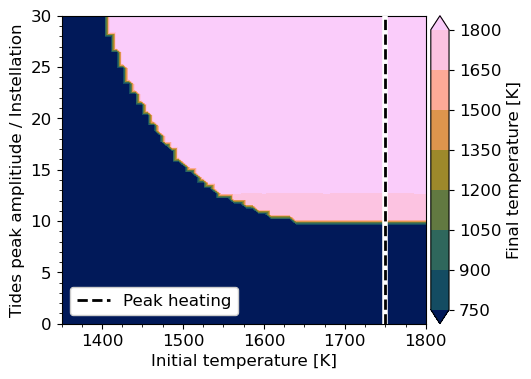

In [30]:
# multiple dimensions
fig, ax = plt.subplots(1,1, figsize=(5,4))

cmap = deepcopy(cm.batlow)
norm = mpl.colors.Normalize(vmin=np.percentile(z_arr,45), vmax=np.percentile(z_arr,55))
mp = ax.tricontourf(x_arr, y_arr, z_arr, cmap=cmap, norm=norm, levels=8, zorder=1, extend='both')

# mixed phase region
ax.axvline(pl.T_cen, color='w',ls='solid', lw=4, zorder=4)
ax.axvline(pl.T_cen, color='k', label="Peak heating", ls='dashed', lw=2, zorder=5)

cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(mp, cax=cax, orientation='vertical')
cbar.set_label("Final temperature [K]")

ax.set_xlabel("Initial temperature [K]")
ax.set_xlim(left=x_arr[0], right=x_arr[-1])
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(25))

ax.set_ylabel("Tides peak amplitiude / Instellation")
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.legend(framealpha=1.0, loc='lower left')

plt.show()
fig.savefig("output/semianalytic_contor.pdf", bbox_inches="tight")

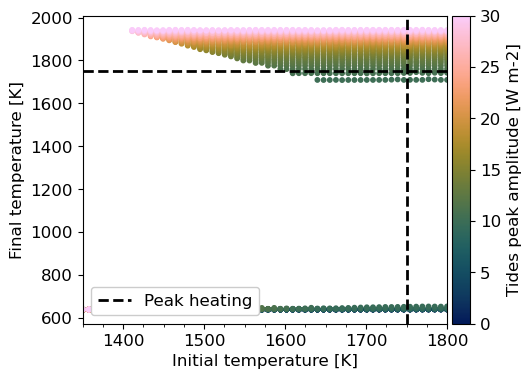

In [40]:
# multiple dimensions
fig, ax = plt.subplots(1,1, figsize=(5,4))

cmap = deepcopy(cm.batlow)
norm = mpl.colors.Normalize(vmin=np.amin(y_arr), vmax=np.amax(y_arr))
mp = ax.scatter(x_arr, z_arr, c=y_arr, cmap=cmap, norm=norm, s=10)

# mixed phase region
ax.axvline(pl.T_cen, color='k', label="Peak heating", ls='dashed', lw=2, zorder=5)
ax.axhline(pl.T_cen, color='k', ls='dashed', lw=2, zorder=5)

cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(mp, cax=cax, orientation='vertical')
cbar.set_label("Tides peak amplitude [W m-2]")

ax.set_xlabel("Initial temperature [K]")
ax.set_xlim(left=x_arr[0], right=x_arr[-1])
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(25))

ax.set_ylabel("Final temperature [K]")
# ax.yaxis.set_major_locator(MultipleLocator(5))
# ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.legend(framealpha=1.0, loc='lower left')

plt.show()
fig.savefig("output/semianalytic_scatter.pdf", bbox_inches="tight")